In [93]:
%qtconsole

In [1]:
import bambi as bmb
import pandas as pd
import numpy as np
import pymc3 as pm
import pymc3.diagnostics as pmd
import statsmodels.api as sm
import pylab
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

//anaconda/envs/python3/lib/python3.5/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


# Load and examine American National Election Studies (ANES) data
These data are from the 2016 pilot study. The full study consisted of 1200 people, but here we've selected the subset of 487 people who responded to a question about whether they would vote for Hillary Clinton or Donald Trump. 

In [2]:
data = pd.read_csv('data/ANES_2016_pilot.csv')
data.head()

,vote,age,party_id
0,clinton,56,democrat
1,trump,65,republican
2,clinton,80,democrat
3,trump,38,republican
4,trump,60,republican


Our outcome variable is `vote`, which gives peoples' responses to the following question prompt:

*"If the 2016 presidential election were between Hillary Clinton for the Democrats and Donald Trump for the Republicans, would you vote for Hillary Clinton, Donald Trump, someone else, or probably not vote?"*

In [40]:
data['vote'].value_counts()

clinton         215
trump           158
someone_else     48
Name: vote, dtype: int64

The two predictors we'll examine are a respondent's `age` and their political party affiliation, `party_id`, which is their response to the following question prompt:

*"Generally speaking, do you usually think of yourself as a Republican, a Democrat, an
independent, or what?"*

In [41]:
data['party_id'].value_counts()

democrat       186
independent    138
republican      97
Name: party_id, dtype: int64

These two predictors are somewhat correlated, but not all that much:

//anaconda/envs/python3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


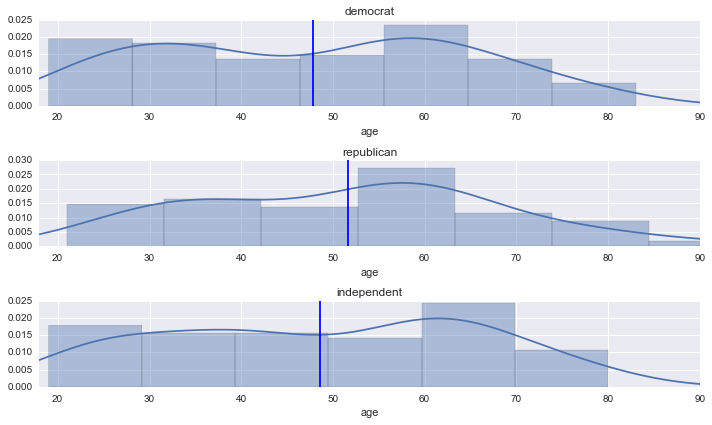

In [20]:
fig, ax = plt.subplots(3, figsize=(10,6))
key = dict(zip(data['party_id'].unique(),range(3)))
for label, df in data.groupby('party_id'):
    sns.distplot(df['age'], ax=ax[key[label]], label=label)
    ax[key[label]].set_xlim([18,90])
    ax[key[label]].set_title(label)
    ax[key[label]].axvline(df['age'].mean())
plt.tight_layout()

We can get a pretty clear idea of how party identification is related to voting intentions by just looking at a contingency table for these two variables:

In [44]:
pd.crosstab(data['vote'], data['party_id'])

party_id,democrat,independent,republican
vote,,,
clinton,159,51,5
someone_else,10,22,16
trump,17,65,76


But our main question here will be: How is respondent age related to voting intentions, and is this relationship different for different party affiliations? For this we will need logistic regression.

# `clinton_model`

To keep this simple, let's look at only the data from people who indicated that they would vote for either Clinton or Trump, and we'll model the probability of voting for Clinton.

In [3]:
clinton_data = data.loc[data['vote'].isin(['clinton','trump']),:]
clinton_data.head()

,vote,age,party_id
0,clinton,56,democrat
1,trump,65,republican
2,clinton,80,democrat
3,trump,38,republican
4,trump,60,republican


Specifying and fitting the model is simple. Notice the (optional) syntax that we use on the left-hand-side of the formula: We say `vote[clinton]` to instruct bambi that we wish the model the probability that `vote=='clinton'`, rather than the probability that `vote=='trump'`. If we leave this unspecified, bambi will just pick one of the events to model, but will inform you which one it picked when you build the model (and again when you look at model summaries.) 

In [4]:
clinton_model = bmb.Model(clinton_data)
clinton_fitted = clinton_model.fit('vote[clinton] ~ party_id + party_id:age',
    family='binomial', link='logit', samples=2000, njobs=2)

//anaconda/envs/python3/lib/python3.5/site-packages/pandas/core/frame.py:2378: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]
/Users/Jake/Desktop/Google Drive/bambi/bambi/models.py:227: UserWarning: Current Bayesian model has not been built yet; building it first before sampling begins.
  warnings.warn("Current Bayesian model has not been built yet; "


Assigned NUTS to b_Intercept
Assigned NUTS to b_party_id
Assigned NUTS to b_party_id:age


/Users/Jake/Desktop/Google Drive/bambi/bambi/models.py:181: UserWarning: Modeling the probability that vote=='clinton'
  self.y.name, str(self.data[self.y.name][event])))


 [-----------------100%-----------------] 2000 of 2000 complete in 21.3 sec

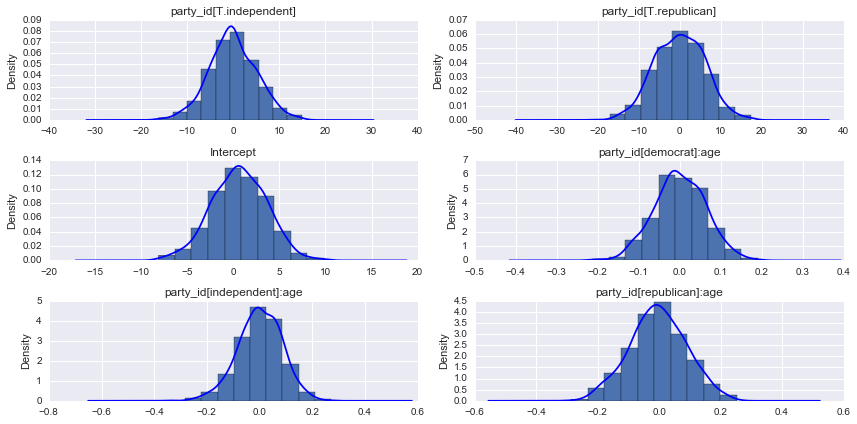

In [5]:
_ = clinton_fitted.plot(kind='priors')

In [6]:
{x.name:x.prior.args for x in clinton_model.terms.values()}

{'Intercept': {'mu': 0.57640750670241292, 'sd': 3.0164301144403476},
 'party_id': {'mu': 0, 'sd': array([[ 5.24531263],
         [ 6.11503291]])},
 'party_id:age': {'mu': 0, 'sd': array([[ 0.06319658],
         [ 0.08076281],
         [ 0.09269321]])}}

/Users/Jake/Desktop/Google Drive/bambi/bambi/results.py:148: UserWarning: Modeling the probability that vote=='clinton'
  self.model.y.name, str(self.model.data[self.model.y.name][event])))


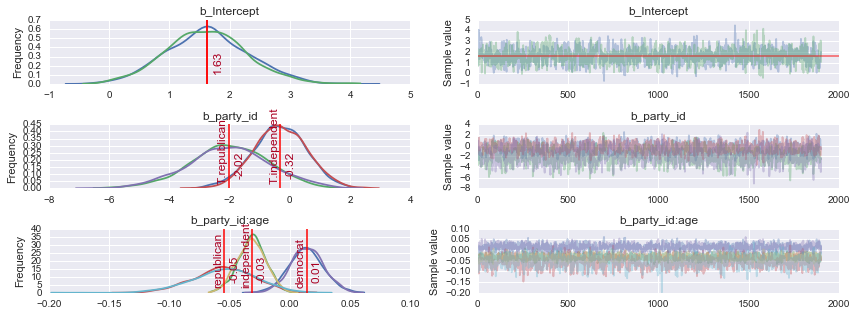

In [8]:
_ = clinton_fitted.plot(burn_in=100)

# Diagnostics

The effective numbers of independent samples for each parameter are:

In [14]:
pmd.effective_n(clinton_fitted.trace[100:])

{'b_Intercept': [1031],
 'b_party_id': [1285, 1086],
 'b_party_id:age': [1083, 2411, 1266]}

And the Gelman-Rubin statistics (we want these to be close to 1) for each parameter are:

In [9]:
pmd.gelman_rubin(clinton_fitted.trace[100:])

{'b_Intercept': array(1.0000259113798677),
 'b_party_id': array([ 1.00046409,  0.99975096]),
 'b_party_id:age': array([ 1.00061602,  1.00029306,  0.99982484])}

# Inferential stuff

Grab the posteriors samples of the `age` slopes for the three `party_id` categories.

In [ ]:
dem, ind, rep = (clinton_fitted.trace[100:]['b_party_id:age'][:,i] for i in range(3))

What is the probability that the Democrat slope is greater than the Republican slope?

In [45]:
(dem > rep).mean()

0.991578947368421

Probability that the Democrat slope is greater than the Independent slope?

In [47]:
(dem > ind).mean()

0.99578947368421056

Probability that the Independent slope is greater than the Republican slope?

In [48]:
(ind > rep).mean()

0.7689473684210526

Probability that the Democrat slope is greater than 0?

In [49]:
(dem > 0).mean()

0.8476315789473684

Probability that the Republican slope is less than 0?

In [50]:
(rep < 0).mean()

0.98236842105263156

Probability that the Independent slope is less than 0?

In [51]:
(ind < 0).mean()

0.99815789473684213

# Spaghetti plot of model predictions

Grab all the MCMC samples.

In [16]:
trace_df = clinton_fitted.get_trace(burn_in=100)
trace_df.head()

,b_Intercept,party_id[T.independent],party_id[T.republican],party_id[democrat]:age,party_id[independent]:age,party_id[republican]:age
0,0.828804,-0.097042,0.035605,0.033793,-0.014147,-0.061860
1,3.310177,-1.855547,-4.607236,-0.026196,-0.030987,-0.025047
2,3.086334,-2.271909,-5.172081,-0.008573,-0.026546,-0.031847
3,2.529677,-1.630117,-2.733155,-0.006620,-0.028646,-0.036853
4,1.805048,-0.041038,-0.193328,0.010157,-0.036662,-0.083242


Separate this into two DataFrames, one containing the intercept for each `party_id`, the other containing the `age` slopes for each `party_id`.

In [23]:
slopes = trace_df.iloc[:,3:]
intercepts = pd.DataFrame({
        'dem': trace_df['b_Intercept'],
        'ind': trace_df['b_Intercept'] + trace_df['party_id[T.independent]'],
        'rep': trace_df['b_Intercept'] + trace_df['party_id[T.republican]']
    })

Compute the predicted values for each posterior sample.

In [36]:
def invlogit(x): return 1/(1+np.exp(-x))
X = np.hstack([np.array([1]*len(np.arange(18, 91)))[:,None],
               np.arange(18, 91)[:,None]])
yhat = [invlogit(np.dot(X, np.vstack([intercepts.iloc[:,i], slopes.iloc[:,i]])))
        for i in range(3)]

Make the plot!

(18, 90)

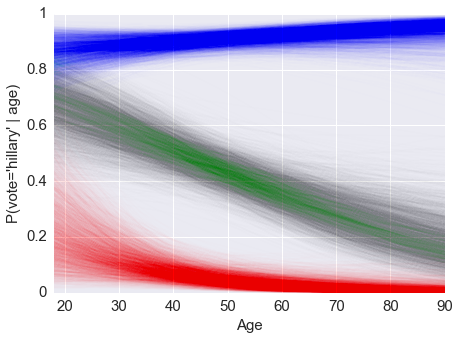

In [39]:
fig, axes = plt.subplots(figsize=(7,5))

cols = ['b','g','r']
for i in range(3):
    for t in range(len(trace_df.index)):
        axes.plot(X[:,1], yhat[i][:,t], alpha=.005, color=cols[i])
axes.set_ylabel('P(vote=\'hillary\' | age)', fontsize=15)
axes.set_xlabel('Age', fontsize=15)
axes.set_yticklabels([0,.2,.4,.6,.8,1], fontsize=15)
axes.set_xticklabels([10,20,30,40,50,60,70,80,90], fontsize=15)
axes.set_xlim(18, 90)